This notebook presents a step-by-step tutorial on using the developed packages for price forecasting.

In [7]:
# Add package folder to Python path
import sys
sys.path.append('./')
import forecasting as fr
import importlib
from sklearn.metrics import mean_absolute_percentage_error
import pandas as pd
importlib.reload(fr.get_data)
importlib.reload(fr.model)
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as mdates

In [2]:
print("add_numbers(1, 2) = ", fr.get_data.add_numbers(1, 2))

add_numbers(1, 2) =  3


## Data acquisition

Import the data as a dataframe. The helper function cleans up the data from API and only gives price and volume data.

NG ESO API - The API is *inclusive* of start date and *exclusive* of the end date.

In [2]:
query_start_date = '2024-06-10'
query_end_date = '2025-06-10'

dcl_data = fr.get_data.get_historical_fr_data_price_volume(query_start_date, query_end_date)

/Users/prashant/Dropbox/Training/DS_SP/Core_DS_Projects/Energy_Price_Forecasting/Mine/Energy-Price-Forecasting/forecasting/get_data.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dcl_data['clearingPrice'] = pd.to_numeric(dcl_data['clearingPrice'], errors='coerce')
/Users/prashant/Dropbox/Training/DS_SP/Core_DS_Projects/Energy_Price_Forecasting/Mine/Energy-Price-Forecasting/forecasting/get_data.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dcl_data['clearedVolume'] = pd.to_numeric(dcl_data['clea

In [4]:
dcl_data.head()

,clearingPrice,clearedVolume
deliveryStart,,
2024-08-21 23:00:00,2.00,1261.0
2024-08-22 03:00:00,2.13,1366.0
2024-08-22 07:00:00,4.35,1207.0
2024-08-22 11:00:00,1.51,1176.0
2024-08-22 15:00:00,2.31,1177.0


## Naive forecast

In [12]:
# Calculate the naive forecast using a rolling average for both price and volume
# Give the data for days -1 (index -7 onwards) to -8 (until index -49) and verify the forecast for day 0.

price_naive_forecast = fr.model.rolling_average_multi_timeperiod(7, 6, dcl_data['clearingPrice'].iloc[:-6])
volume_naive_forecast = fr.model.rolling_average_multi_timeperiod(7, 6, dcl_data['clearedVolume'].iloc[:-6])

# Compare the naive forecast with the actual values for day 0
# Calculate the MAPE
mape_price_naive = mean_absolute_percentage_error(dcl_data['clearingPrice'].iloc[-6:], price_naive_forecast)
mape_volume_naive = mean_absolute_percentage_error(dcl_data['clearedVolume'].iloc[-6:], volume_naive_forecast)

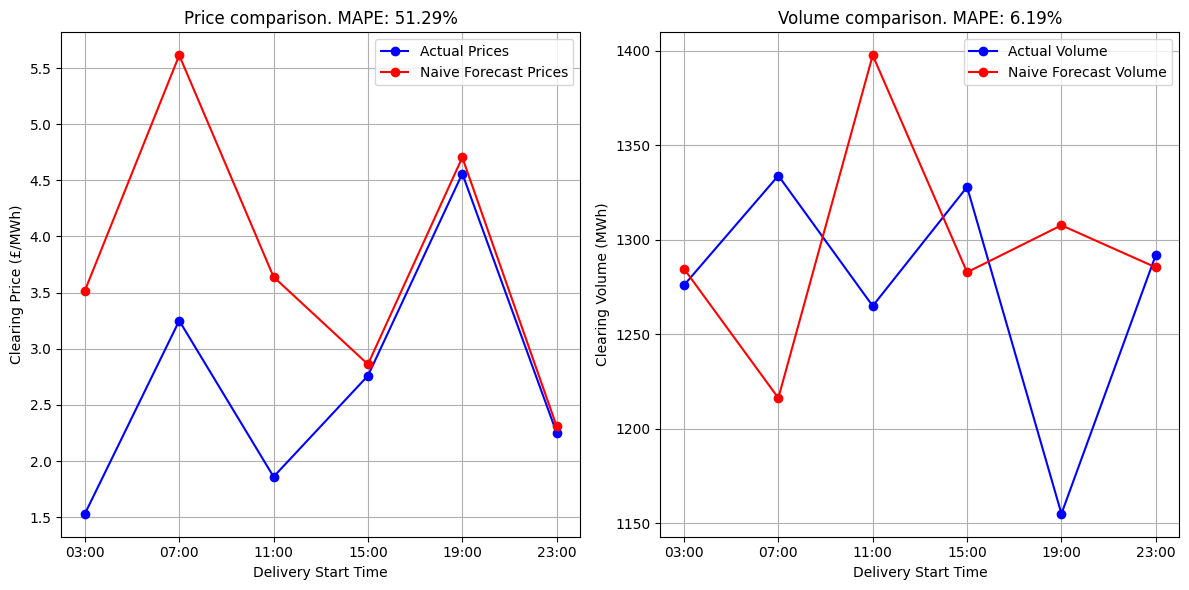

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

timestamp = dcl_data.index[-6:]

# First the price plot
ax1.plot(timestamp, dcl_data['clearingPrice'].iloc[-6:], marker='o', linestyle='-', color='blue', label='Actual Prices')
ax1.plot(timestamp, price_naive_forecast, marker='o', linestyle='-', color='red', label='Naive Forecast Prices')

ax1.set_xlabel('Delivery Start Time')
ax1.set_ylabel('Clearing Price (£/MWh)')
ax1.set_title('Price comparison. MAPE: {:.2f}%'.format(mape_price_naive * 100))
ax1.legend()

ax1.set_xticks(timestamp) # Shows ticks only at actual data points
ax1.set_xticklabels(timestamp.strftime("%H:%M"), rotation=0) # Shows only the hour and minute
ax1.grid(True)

# Next the volume plot
ax2.plot(timestamp, dcl_data['clearedVolume'].iloc[-6:], marker='o', linestyle='-', color='blue', label='Actual Volume')
ax2.plot(timestamp, volume_naive_forecast, marker='o', linestyle='-', color='red', label='Naive Forecast Volume')

ax2.set_xlabel('Delivery Start Time')
ax2.set_ylabel('Clearing Volume (MWh)')
ax2.set_title('Volume comparison. MAPE: {:.2f}%'.format(mape_volume_naive * 100))
ax2.legend()
ax2.set_xticks(timestamp) # Shows ticks only at actual data points
ax2.set_xticklabels(timestamp.strftime("%H:%M"), rotation=0) # Shows only the hour and minute
ax2.grid(True)


plt.tight_layout()
plt.show()

In [18]:
type(timestamp)

pandas.core.indexes.datetimes.DatetimeIndex

In [19]:
timestamp

DatetimeIndex(['2025-06-09 03:00:00', '2025-06-09 07:00:00',
               '2025-06-09 11:00:00', '2025-06-09 15:00:00',
               '2025-06-09 19:00:00', '2025-06-09 23:00:00'],
              dtype='datetime64[ns]', name='deliveryStart', freq=None)